In [ ]:
import os, sys 
import torch 
import datetime
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import IPython.display as ipd
from argparse import Namespace
import torch.nn as nn 
import torch.nn.functional as F
import librosa
import argparse
import scipy 
import IPython.display as ipd
import numpy as np
from matplotlib.pyplot import cm
from tqdm import tqdm
import time
import comet_ml
from pprint import pprint
import pandas as pd
from glob2 import glob

import torch
import os
import sys
import copy
import IPython
import numpy as np
import matplotlib.pyplot as plt
from asteroid.losses import pairwise_neg_sisdr
from asteroid.losses import pairwise_neg_snr

import baseline.dataset_loaders.chime as chime
import baseline.utils.mixture_consistency as mixture_consistency
import baseline.models.improved_sudormrf as improved_sudormrf
import baseline.metrics.dnnmos_metric as dnnmos_metric

import pickle

sys.path.append("../")
# from __config__ import *
# plt.style.use('science')
# plt.style.use(['science','ieee','no-latex'])
# plt.style.reload_library()
# plt.style.use(['science', 'ieee'])

# os.environ["CUDA_VISIBLE_DEVICES"] = ",".join(["0", "1"])
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join(["2"])



In [57]:
batch_size = 1
sample_rate = 16000
timelength = 4.
fixed_n_sources = 1
get_only_active_speakers = False
split = 'dev'
random_order = True
n_samples = 250
time_samples = int(sample_rate * timelength)
data_loader = chime.Dataset(
    sample_rate=sample_rate, fixed_n_sources=fixed_n_sources,
    timelength=timelength, augment=random_order,
    zero_pad=True, split=split, get_only_active_speakers=get_only_active_speakers,
    normalize_audio=False, n_samples=n_samples)
val_chime_gen = data_loader.get_generator(
    batch_size=batch_size, num_workers=1) 

data_loader = chime.Dataset(
    sample_rate=sample_rate, fixed_n_sources=fixed_n_sources,
    timelength=timelength, augment=random_order,
    zero_pad=True, split='eval', get_only_active_speakers=get_only_active_speakers,
    normalize_audio=False, n_samples=n_samples)
eval_chime_gen = data_loader.get_generator(
    batch_size=batch_size, num_workers=1) 

def get_new_student(hparams, depth_growth):
    student = improved_sudormrf.SuDORMRF(
        out_channels=hparams["out_channels"],
        in_channels=hparams["in_channels"],
        num_blocks=int(depth_growth * hparams["num_blocks"]),
        upsampling_depth=hparams["upsampling_depth"],
        enc_kernel_size=hparams["enc_kernel_size"],
        enc_num_basis=hparams["enc_num_basis"],
        num_sources=2,
    )
    return student

hparams = {
    'out_channels': 512,
    'in_channels': 512,
    'num_blocks': 8,
    'upsampling_depth': 7,
    'enc_kernel_size': 41,
    'enc_num_basis': 512,
}

wo_mix_con_chkpt = "/home/thymios/projects/unsup_speech_enh_adaptation/pretrained_checkpoints/libri1to3_sup_teacher.pt"
wo_mix_con_model = get_new_student(hparams, depth_growth=1)
wo_mix_con_model.load_state_dict(torch.load(wo_mix_con_chkpt))
wo_mix_con_model = wo_mix_con_model.cuda()

/home/thymios/projects/unsup_speech_enh_adaptation/baseline/dataset_loaders/abstract_dataset.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_wav = torch.tensor(


Initial Mixture


Estimated Teacher Speech


Teacher Estimated Noise


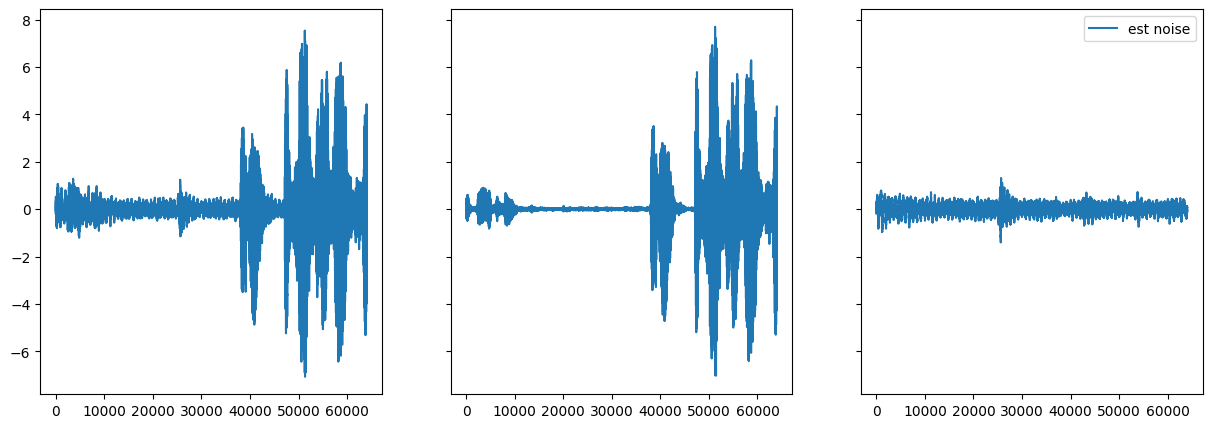

{'sig_mos': 3.46368085560458, 'bak_mos': 1.6402234135550935, 'ovr_mos': 1.9670919183667817}
Initial Mixture


Estimated Teacher Speech


Teacher Estimated Noise


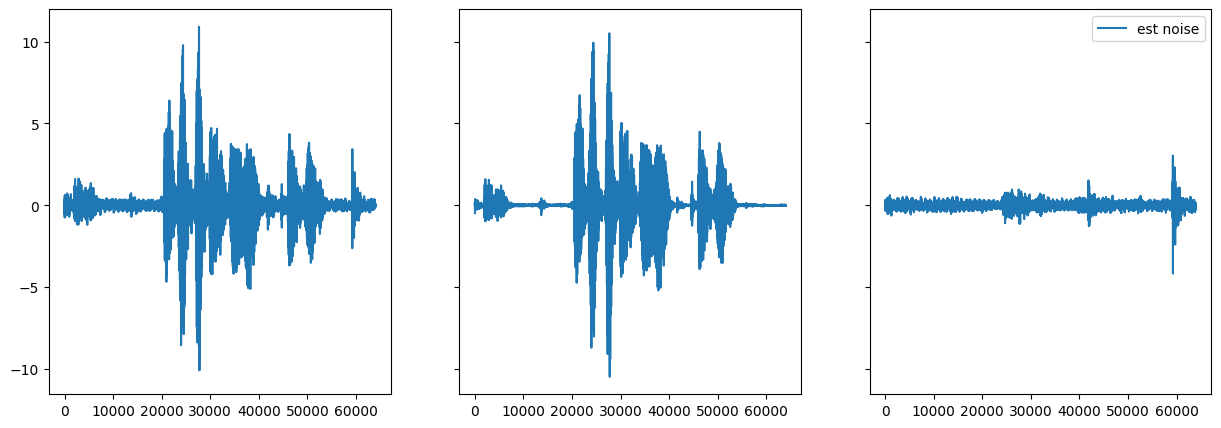

{'sig_mos': 3.438434602819757, 'bak_mos': 2.841854427744949, 'ovr_mos': 3.150598446711665}
Initial Mixture


Estimated Teacher Speech


Teacher Estimated Noise


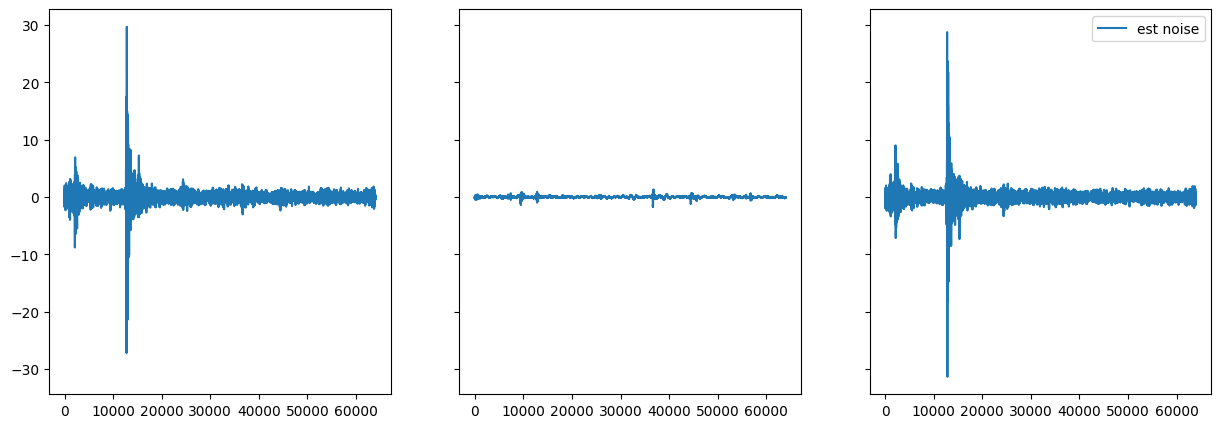

{'sig_mos': 2.849813518599298, 'bak_mos': 1.4271761829625158, 'ovr_mos': 2.111952777890476}
Initial Mixture


Estimated Teacher Speech


Teacher Estimated Noise


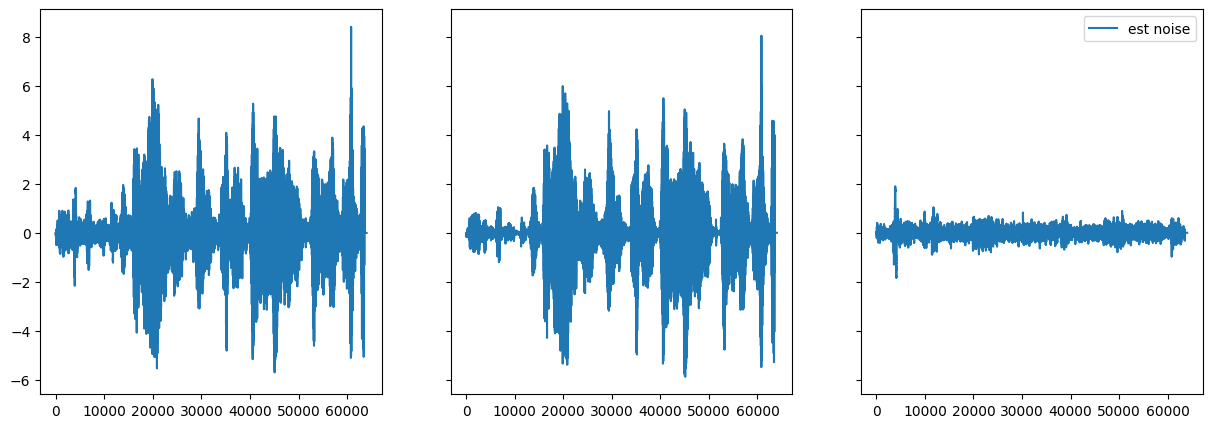

{'sig_mos': 3.7496099254177224, 'bak_mos': 1.7924324945613663, 'ovr_mos': 2.138528193035247}
Initial Mixture


Estimated Teacher Speech


Teacher Estimated Noise


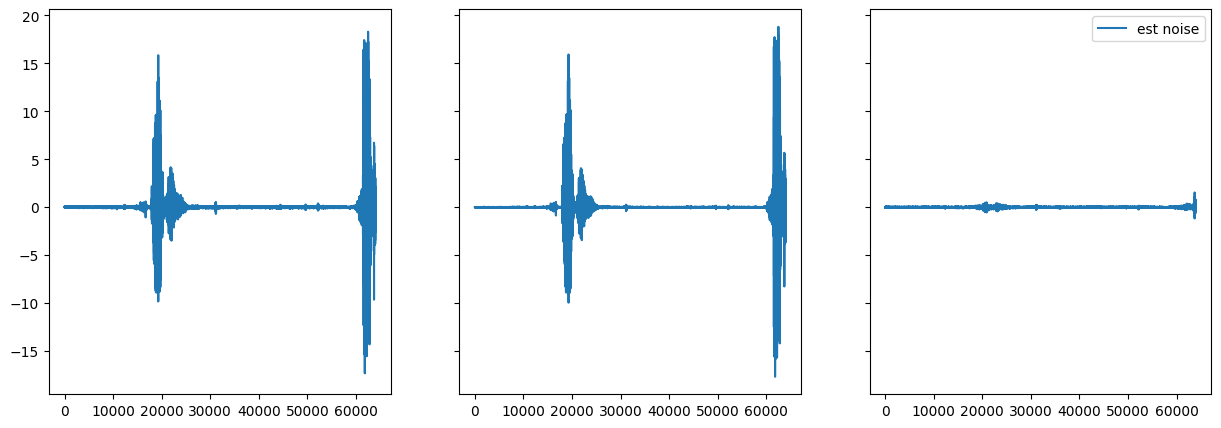

{'sig_mos': 3.3325005466683724, 'bak_mos': 1.7575149379852006, 'ovr_mos': 1.9101148614969774}
Initial Mixture


Estimated Teacher Speech


Teacher Estimated Noise


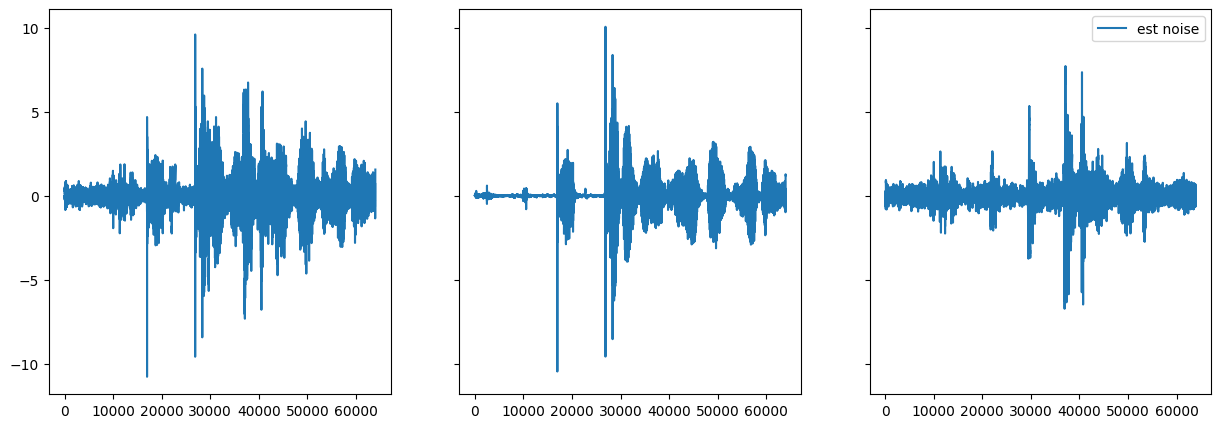

{'sig_mos': 3.4009814889812455, 'bak_mos': 1.8819768914270163, 'ovr_mos': 2.2124753086286377}
Initial Mixture


Estimated Teacher Speech


Teacher Estimated Noise


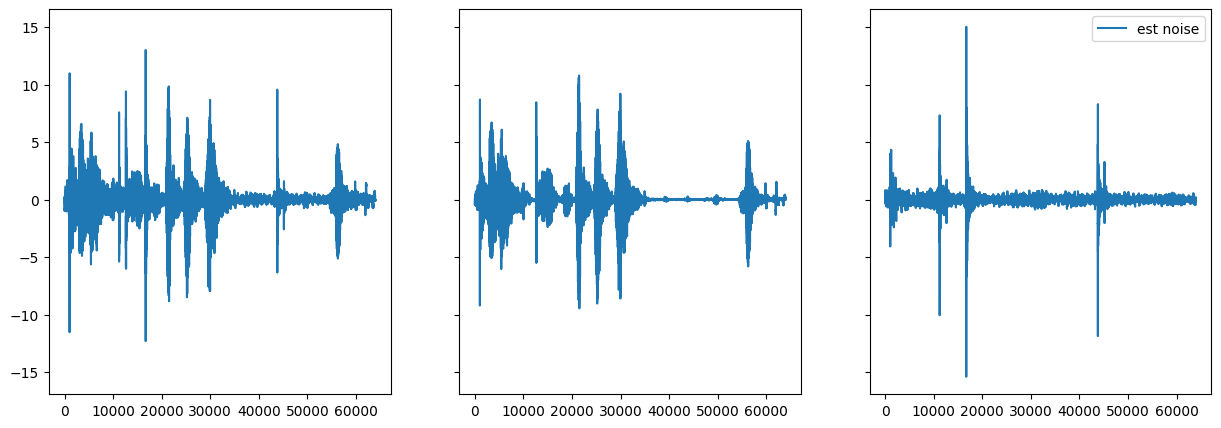

{'sig_mos': 3.4339919851603, 'bak_mos': 2.03768910865635, 'ovr_mos': 2.502650214043222}
Initial Mixture


Estimated Teacher Speech


Teacher Estimated Noise


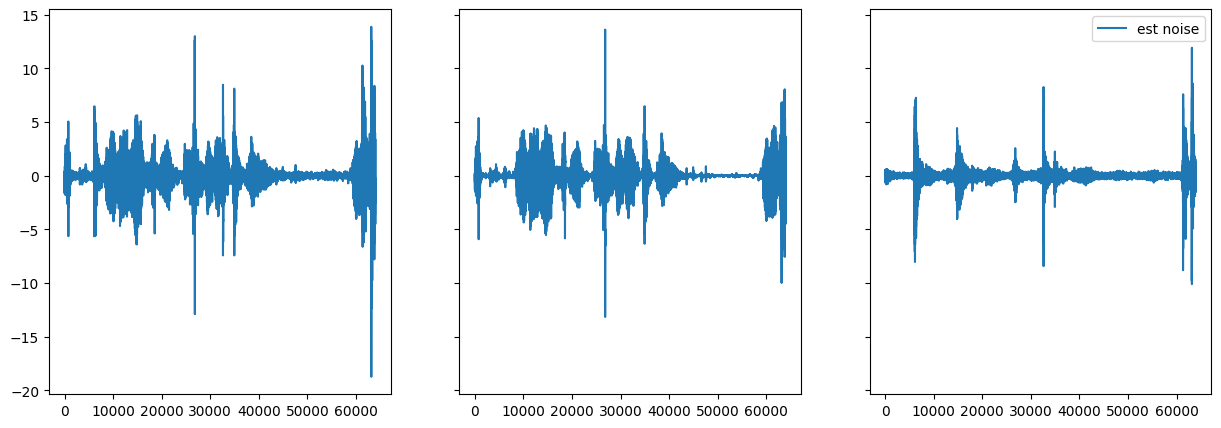

{'sig_mos': 3.368253875587869, 'bak_mos': 1.9507073518710556, 'ovr_mos': 2.3107030165822096}
Initial Mixture


Estimated Teacher Speech


Teacher Estimated Noise


{'sig_mos': 3.638514043184441, 'bak_mos': 2.7628978109247893, 'ovr_mos': 3.2887844295302218}
Initial Mixture


Estimated Teacher Speech


Teacher Estimated Noise


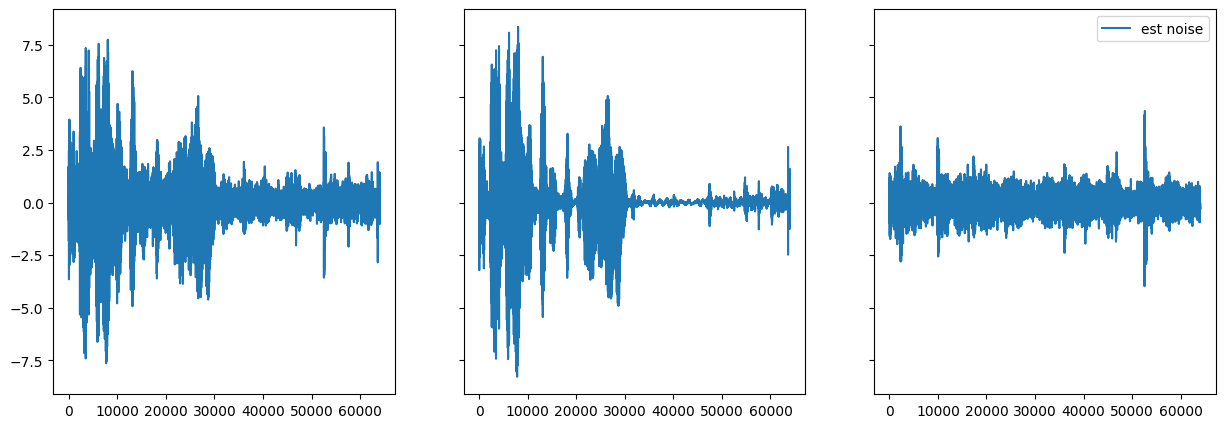

{'sig_mos': 3.829976509939112, 'bak_mos': 2.462909331865574, 'ovr_mos': 2.805257569798519}
Initial Mixture


Estimated Teacher Speech


Teacher Estimated Noise


{'sig_mos': 2.824859439942283, 'bak_mos': 1.9201499965011422, 'ovr_mos': 2.0263214062133756}
Initial Mixture


Estimated Teacher Speech


Teacher Estimated Noise


{'sig_mos': 2.9289891620976873, 'bak_mos': 2.3683320757005877, 'ovr_mos': 2.1228994029022217}


In [56]:
wo_mix_con_model.eval()
for cnt, mixture in enumerate(eval_chime_gen):
    input_mix = mixture.unsqueeze(1).cuda()
    input_mix_std = input_mix.std(-1, keepdim=True)
    input_mix_mean = input_mix.mean(-1, keepdim=True)
    input_mix = (input_mix - input_mix_mean) / (input_mix_std + 1e-9)

    with torch.no_grad():
        rec_sources_wavs = wo_mix_con_model(input_mix)
        
        new_mix = rec_sources_wavs[:, 0:1] + rec_sources_wavs[:, 1:]
        new_mix_std = new_mix.std(-1, keepdim=True)
        new_mix_mean = new_mix.mean(-1, keepdim=True)
        rec_sources_wavs = (rec_sources_wavs - new_mix_mean) / (new_mix_std + 1e-9)
        
#         rec_sources_wavs = (rec_sources_wavs * new_mix_std) + new_mix_mean
        teacher_est_active_speakers = rec_sources_wavs[:, 0:1].detach().cpu()
        teacher_est_noises = rec_sources_wavs[:, 1:].detach().cpu()

    # Play the mixture and the estimated sources
    mix, est_s, est_n = input_mix[0, 0].cpu().numpy(), teacher_est_active_speakers[0, 0].cpu().numpy(), teacher_est_noises[0, 0].cpu().numpy()
    print("Initial Mixture")
    ipd.display(ipd.Audio(input_mix[0:, 0].cpu().numpy(), rate=16000))
    
    print("Estimated Teacher Speech")
    ipd.display(ipd.Audio(teacher_est_active_speakers[0:, 0].detach().numpy(), rate=16000))
    print("Teacher Estimated Noise")
    ipd.display(ipd.Audio(teacher_est_noises[0:, 0].detach().numpy(), rate=16000))
    
    # Plot the mixture and the estimated sources
    fig, ax = plt.subplots(1, 3, figsize=(15,5), sharey=True)
    ax[0].plot(mix, label="mixture")
    ax[1].plot(est_s, label="est speaker mix")
    ax[2].plot(est_n, label="est noise")
    plt.legend()
    plt.show()
    plt.close()
    
    # MEasure the DNSMOS
    dnsmos_val = dnnmos_metric.compute_dnsmos(est_s, fs=16000)
    print(dnsmos_val)
        
    if cnt > 10:
        break

In [58]:
# Extract proper numbers for val and test for DNS-MOS
eval_res_dic = {'sig_mos': [], 'bak_mos': [], 'ovr_mos': []}
wo_mix_con_model.eval()
for cnt, mixture in tqdm(enumerate(eval_chime_gen)):
    input_mix = mixture.unsqueeze(1).cuda()
    input_mix_std = input_mix.std(-1, keepdim=True)
    input_mix_mean = input_mix.mean(-1, keepdim=True)
    input_mix = (input_mix - input_mix_mean) / (input_mix_std + 1e-9)

    with torch.no_grad():
        rec_sources_wavs = wo_mix_con_model(input_mix)
        
        new_mix = rec_sources_wavs[:, 0:1] + rec_sources_wavs[:, 1:]
        new_mix_std = new_mix.std(-1, keepdim=True)
        new_mix_mean = new_mix.mean(-1, keepdim=True)
        rec_sources_wavs = (rec_sources_wavs - new_mix_mean) / (new_mix_std + 1e-9)
        
#         rec_sources_wavs = (rec_sources_wavs * new_mix_std) + new_mix_mean
        teacher_est_active_speakers = rec_sources_wavs[:, 0:1].detach().cpu()
        teacher_est_noises = rec_sources_wavs[:, 1:].detach().cpu()

    mix, est_s, est_n = input_mix[0, 0].cpu().numpy(), teacher_est_active_speakers[0, 0].cpu().numpy(), teacher_est_noises[0, 0].cpu().numpy()
    
    # MEasure the DNSMOS
    dnsmos_val = dnnmos_metric.compute_dnsmos(est_s, fs=16000)
    for k, v in dnsmos_val.items():
        eval_res_dic[k].append(v)
    
    if cnt > 250:
        break

val_res_dic = {'sig_mos': [], 'bak_mos': [], 'ovr_mos': []}
wo_mix_con_model.eval()
for cnt, mixture in tqdm(enumerate(val_chime_gen)):
    input_mix = mixture.unsqueeze(1).cuda()
    input_mix_std = input_mix.std(-1, keepdim=True)
    input_mix_mean = input_mix.mean(-1, keepdim=True)
    input_mix = (input_mix - input_mix_mean) / (input_mix_std + 1e-9)

    with torch.no_grad():
        rec_sources_wavs = wo_mix_con_model(input_mix)
        
        new_mix = rec_sources_wavs[:, 0:1] + rec_sources_wavs[:, 1:]
        new_mix_std = new_mix.std(-1, keepdim=True)
        new_mix_mean = new_mix.mean(-1, keepdim=True)
        rec_sources_wavs = (rec_sources_wavs - new_mix_mean) / (new_mix_std + 1e-9)
        
#         rec_sources_wavs = (rec_sources_wavs * new_mix_std) + new_mix_mean
        teacher_est_active_speakers = rec_sources_wavs[:, 0:1].detach().cpu()
        teacher_est_noises = rec_sources_wavs[:, 1:].detach().cpu()

    mix, est_s, est_n = input_mix[0, 0].cpu().numpy(), teacher_est_active_speakers[0, 0].cpu().numpy(), teacher_est_noises[0, 0].cpu().numpy()
    
    # MEasure the DNSMOS
    dnsmos_val = dnnmos_metric.compute_dnsmos(est_s, fs=16000)
    for k, v in dnsmos_val.items():
        val_res_dic[k].append(v)
    
    if cnt > 250:
        break

0it [00:00, ?it/s]/home/thymios/projects/unsup_speech_enh_adaptation/baseline/dataset_loaders/abstract_dataset.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_wav = torch.tensor(
250it [15:30,  3.72s/it]
0it [00:00, ?it/s]/home/thymios/projects/unsup_speech_enh_adaptation/baseline/dataset_loaders/abstract_dataset.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_wav = torch.tensor(
250it [10:13,  2.46s/it]


In [59]:
for name, this_dic in [('val', val_res_dic), ('eval', eval_res_dic)]:
    print(name)
    for k, v in this_dic.items():
        print(k, np.median(v))

val
sig_mos 3.319384919281288
bak_mos 2.2131798659849995
ovr_mos 2.3460607864004377
eval
sig_mos 3.2129001597440947
bak_mos 1.9378379391263179
ovr_mos 2.207511791898093


In [35]:
# First 100 files
# val
# sig_mos 3.2984661443007415
# bak_mos 2.0822932936507637
# ovr_mos 2.43831652347599
# eval
# sig_mos 3.1621492561089672
# bak_mos 1.7948609791799695
# ovr_mos 2.2057024473983646

# First 150 files
# val
# sig_mos 3.281661956463196
# bak_mos 2.072647628157454
# ovr_mos 2.4072931739494496
# eval
# sig_mos 3.1567512059053207
# bak_mos 1.8039216863287497
# ovr_mos 2.228261702772584

# Random 150 files
# val
# sig_mos 3.219910796625348
# bak_mos 2.1603549580049597
# ovr_mos 2.3498571683475413
# eval
# sig_mos 3.184163095649329
# bak_mos 1.7326153625752412
# ovr_mos 2.223591904771052

# First 200 files
# val
# sig_mos 3.2656235159548603
# bak_mos 2.0520309031854573
# ovr_mos 2.390775027974467
# eval
# sig_mos 3.1572359126359113
# bak_mos 1.8514009046715056
# ovr_mos 2.248262773910106

# First 800 files
# val
# sig_mos 3.2593691441864405
# bak_mos 2.125011545789507
# ovr_mos 2.389107041858496
# eval
# sig_mos 3.1729439302593154
# bak_mos 1.8325005000678685
# ovr_mos 2.2433430122370632

# Random 800 files
# val
# sig_mos 3.2371230296094895
# bak_mos 2.1766570353095362
# ovr_mos 2.3978993580066175
# eval
# sig_mos 3.167143649617164
# bak_mos 1.8197346619575203
# ovr_mos 2.2510711906727465

# and median values for random 800 files
# val
# sig_mos 3.2690846758425858
# bak_mos 2.279107268518354
# ovr_mos 2.3516808202002215
# eval
# sig_mos 3.2204296532023147
# bak_mos 1.9621628525079884
# ovr_mos 2.2123291898643846

/home/thymios/projects/unsup_speech_enh_adaptation/baseline/dataset_loaders/abstract_dataset.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_wav = torch.tensor(


Initial Mixture


Estimated Teacher Speech


Teacher Estimated Noise


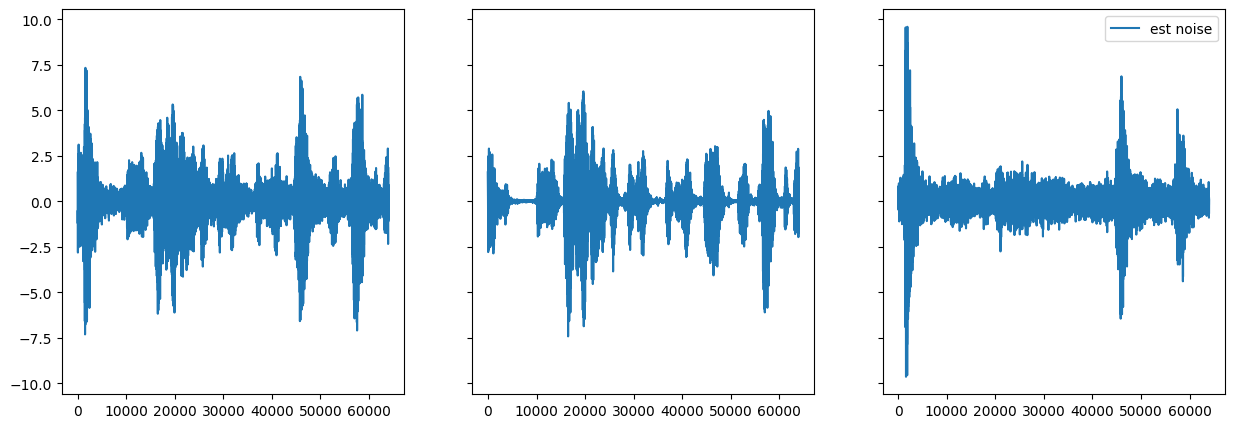

{'sig_mos': 3.297868174718961, 'bak_mos': 1.0664763639320916, 'ovr_mos': 2.2445124110649544}


/home/thymios/projects/unsup_speech_enh_adaptation/baseline/dataset_loaders/abstract_dataset.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_wav = torch.tensor(


Initial Mixture


Estimated Teacher Speech


Teacher Estimated Noise


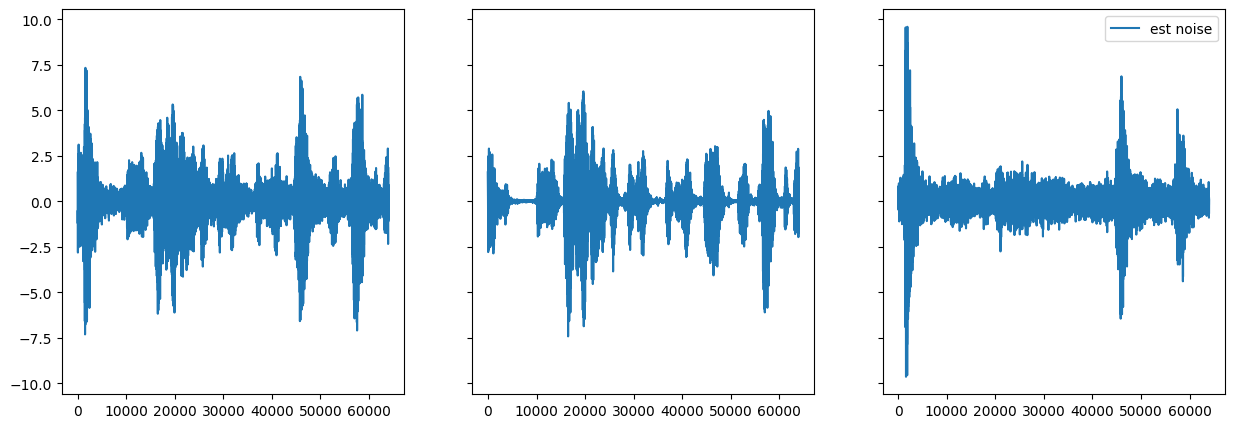

{'sig_mos': 3.297868174718961, 'bak_mos': 1.0664764828550881, 'ovr_mos': 2.2445124110649544}


In [48]:
batch_size = 1
sample_rate = 16000
timelength = 4.
fixed_n_sources = 1
get_only_active_speakers = False
split = 'train'
random_order = False
n_samples = -1
time_samples = int(sample_rate * timelength)
data_loader = chime.Dataset(
    sample_rate=sample_rate, fixed_n_sources=fixed_n_sources,
    timelength=timelength, augment=random_order,
    zero_pad=True, split=split, get_only_active_speakers=get_only_active_speakers,
    normalize_audio=False, n_samples=n_samples)
train_chime_gen = data_loader.get_generator(
    batch_size=batch_size, num_workers=1) 

for i in range(2):
    initial_seed = 11
    torch.manual_seed(initial_seed + i)
    np.random.seed(initial_seed + i)
    
    wo_mix_con_model.eval()
    for cnt, mixture in enumerate(train_chime_gen):
        input_mix = mixture.unsqueeze(1).cuda()
        input_mix_std = input_mix.std(-1, keepdim=True)
        input_mix_mean = input_mix.mean(-1, keepdim=True)
        input_mix = (input_mix - input_mix_mean) / (input_mix_std + 1e-9)

        with torch.no_grad():
            rec_sources_wavs = wo_mix_con_model(input_mix)

            new_mix = rec_sources_wavs[:, 0:1] + rec_sources_wavs[:, 1:]
            new_mix_std = new_mix.std(-1, keepdim=True)
            new_mix_mean = new_mix.mean(-1, keepdim=True)
            rec_sources_wavs = (rec_sources_wavs - new_mix_mean) / (new_mix_std + 1e-9)

    #         rec_sources_wavs = (rec_sources_wavs * new_mix_std) + new_mix_mean
            teacher_est_active_speakers = rec_sources_wavs[:, 0:1].detach().cpu()
            teacher_est_noises = rec_sources_wavs[:, 1:].detach().cpu()

        # Play the mixture and the estimated sources
        mix, est_s, est_n = input_mix[0, 0].cpu().numpy(), teacher_est_active_speakers[0, 0].cpu().numpy(), teacher_est_noises[0, 0].cpu().numpy()
        print("Initial Mixture")
        ipd.display(ipd.Audio(input_mix[0:, 0].cpu().numpy(), rate=16000))

        print("Estimated Teacher Speech")
        ipd.display(ipd.Audio(teacher_est_active_speakers[0:, 0].detach().numpy(), rate=16000))
        print("Teacher Estimated Noise")
        ipd.display(ipd.Audio(teacher_est_noises[0:, 0].detach().numpy(), rate=16000))

        # Plot the mixture and the estimated sources
        fig, ax = plt.subplots(1, 3, figsize=(15,5), sharey=True)
        ax[0].plot(mix, label="mixture")
        ax[1].plot(est_s, label="est speaker mix")
        ax[2].plot(est_n, label="est noise")
        plt.legend()
        plt.show()
        plt.close()

        # MEasure the DNSMOS
        dnsmos_val = dnnmos_metric.compute_dnsmos(est_s, fs=16000)
        print(dnsmos_val)

        if cnt > -1:
            break

In [60]:
# Test a model with mixture consistency
batch_size = 1
sample_rate = 16000
timelength = 4.
fixed_n_sources = 1
get_only_active_speakers = False
split = 'dev'
random_order = False
n_samples = 250
time_samples = int(sample_rate * timelength)
data_loader = chime.Dataset(
    sample_rate=sample_rate, fixed_n_sources=fixed_n_sources,
    timelength=timelength, augment=random_order,
    zero_pad=True, split=split, get_only_active_speakers=get_only_active_speakers,
    normalize_audio=False, n_samples=n_samples)
val_chime_gen = data_loader.get_generator(
    batch_size=batch_size, num_workers=1) 

data_loader = chime.Dataset(
    sample_rate=sample_rate, fixed_n_sources=fixed_n_sources,
    timelength=timelength, augment=random_order,
    zero_pad=True, split='eval', get_only_active_speakers=get_only_active_speakers,
    normalize_audio=False, n_samples=n_samples)
eval_chime_gen = data_loader.get_generator(
    batch_size=batch_size, num_workers=1) 

def get_new_student(hparams, depth_growth):
    student = improved_sudormrf.SuDORMRF(
        out_channels=hparams["out_channels"],
        in_channels=hparams["in_channels"],
        num_blocks=int(depth_growth * hparams["num_blocks"]),
        upsampling_depth=hparams["upsampling_depth"],
        enc_kernel_size=hparams["enc_kernel_size"],
        enc_num_basis=hparams["enc_num_basis"],
        num_sources=2,
    )
    return student

hparams = {
    'out_channels': 512,
    'in_channels': 512,
    'num_blocks': 8,
    'upsampling_depth': 7,
    'enc_kernel_size': 41,
    'enc_num_basis': 512,
}

w_mix_con_chkpt = "/mnt/data/thymios_backup/thymios/UCHIME_checkpoints/ublock8_sup_teacher_libri1to3mix_0.5single_w_mixcon/sup_teacher_epoch_100.pt"
w_mix_con_model = get_new_student(hparams, depth_growth=1)
w_mix_con_model.load_state_dict(torch.load(w_mix_con_chkpt))
w_mix_con_model = w_mix_con_model.cuda()

In [61]:
# Extract proper numbers for val and test for DNS-MOS
eval_res_dic = {'sig_mos': [], 'bak_mos': [], 'ovr_mos': []}
w_mix_con_model.eval()
for cnt, mixture in tqdm(enumerate(eval_chime_gen)):
    input_mix = mixture.unsqueeze(1).cuda()
    input_mix_std = input_mix.std(-1, keepdim=True)
    input_mix_mean = input_mix.mean(-1, keepdim=True)
    input_mix = (input_mix - input_mix_mean) / (input_mix_std + 1e-9)

    with torch.no_grad():
        rec_sources_wavs = w_mix_con_model(input_mix)
        rec_sources_wavs = mixture_consistency.apply(rec_sources_wavs, input_mix)

        new_mix = rec_sources_wavs[:, 0:1] + rec_sources_wavs[:, 1:]
        new_mix_std = new_mix.std(-1, keepdim=True)
        new_mix_mean = new_mix.mean(-1, keepdim=True)
        rec_sources_wavs = (rec_sources_wavs - new_mix_mean) / (new_mix_std + 1e-9)
        
#         rec_sources_wavs = (rec_sources_wavs * new_mix_std) + new_mix_mean
        teacher_est_active_speakers = rec_sources_wavs[:, 0:1].detach().cpu()
        teacher_est_noises = rec_sources_wavs[:, 1:].detach().cpu()

    mix, est_s, est_n = input_mix[0, 0].cpu().numpy(), teacher_est_active_speakers[0, 0].cpu().numpy(), teacher_est_noises[0, 0].cpu().numpy()
    
    # MEasure the DNSMOS
    dnsmos_val = dnnmos_metric.compute_dnsmos(mix, fs=16000)
    for k, v in dnsmos_val.items():
        eval_res_dic[k].append(v)
    
    if cnt > 250:
        break

val_res_dic = {'sig_mos': [], 'bak_mos': [], 'ovr_mos': []}
wo_mix_con_model.eval()
for cnt, mixture in tqdm(enumerate(val_chime_gen)):
    input_mix = mixture.unsqueeze(1).cuda()
    input_mix_std = input_mix.std(-1, keepdim=True)
    input_mix_mean = input_mix.mean(-1, keepdim=True)
    input_mix = (input_mix - input_mix_mean) / (input_mix_std + 1e-9)

    with torch.no_grad():
        rec_sources_wavs = w_mix_con_model(input_mix)
        rec_sources_wavs = mixture_consistency.apply(rec_sources_wavs, input_mix)
        
        new_mix = rec_sources_wavs[:, 0:1] + rec_sources_wavs[:, 1:]
        new_mix_std = new_mix.std(-1, keepdim=True)
        new_mix_mean = new_mix.mean(-1, keepdim=True)
        rec_sources_wavs = (rec_sources_wavs - new_mix_mean) / (new_mix_std + 1e-9)
        
#         rec_sources_wavs = (rec_sources_wavs * new_mix_std) + new_mix_mean
        teacher_est_active_speakers = rec_sources_wavs[:, 0:1].detach().cpu()
        teacher_est_noises = rec_sources_wavs[:, 1:].detach().cpu()

    mix, est_s, est_n = input_mix[0, 0].cpu().numpy(), teacher_est_active_speakers[0, 0].cpu().numpy(), teacher_est_noises[0, 0].cpu().numpy()
    
    # MEasure the DNSMOS
    dnsmos_val = dnnmos_metric.compute_dnsmos(mix, fs=16000)
    for k, v in dnsmos_val.items():
        val_res_dic[k].append(v)
    
    if cnt > 250:
        break

0it [00:00, ?it/s]/home/thymios/projects/unsup_speech_enh_adaptation/baseline/dataset_loaders/abstract_dataset.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_wav = torch.tensor(
250it [10:15,  2.46s/it]
0it [00:00, ?it/s]/home/thymios/projects/unsup_speech_enh_adaptation/baseline/dataset_loaders/abstract_dataset.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_wav = torch.tensor(
250it [13:19,  3.20s/it]


In [62]:
for name, this_dic in [('val', val_res_dic), ('eval', eval_res_dic)]:
    print(name)
    for k, v in this_dic.items():
        print(k, np.median(v))

val
sig_mos 3.3056137709971987
bak_mos 0.5633181996865181
ovr_mos 2.0245726312936863
eval
sig_mos 3.2073859607592086
bak_mos 0.620942997645105
ovr_mos 1.9920248930725843


In [ ]:
# First 150 files
# val
# sig_mos 3.229351682723843
# bak_mos 2.3863286680083275
# ovr_mos 2.3221165278411355
# eval
# sig_mos 3.1871674020953122
# bak_mos 2.0101527124062697
# ovr_mos 2.1598378068538975

# First 250 files
# val
# sig_mos 3.2413193036956383
# bak_mos 2.3690752002204305
# ovr_mos 2.3155341089748758
# eval
# sig_mos 3.1692616596395253
# bak_mos 2.093653855689381
# ovr_mos 2.1628214491552917

# Mixture 150 files
# val
# sig_mos 3.3056137709971987
# bak_mos 0.5633181996865181
# ovr_mos 2.0245726312936863
# eval
# sig_mos 3.2073859607592086
# bak_mos 0.620942997645105
# ovr_mos 1.9920248930725843